In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from fbprophet import Prophet
import pmdarima as pm


Importing plotly failed. Interactive plots will not work.


Pulling in Data from KU_Pandas_for_database for a trial run of the Machine Learning Model

In [2]:
import yfinance as yf
df_ch_robinson = yf.download('CHRW', start='2019-01-01', end='2022-01-01', progress=False)

df_ch_robinson.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,82.669998,83.800003,82.220001,82.980003,76.134377,937200
2019-01-03,82.139999,82.709999,79.820000,79.919998,73.326836,1127400
2019-01-04,80.940002,83.160004,80.919998,82.690002,75.868301,1724700
2019-01-07,82.339996,83.639999,81.580002,83.089996,76.235313,1311600
2019-01-08,83.580002,84.059998,83.010002,83.760002,76.850052,1085800


In [3]:
df_sp = yf.download('^GSPC', start='2019-01-01', end='2022-01-01', progress=False)

Plotting Closing Price to visualize 

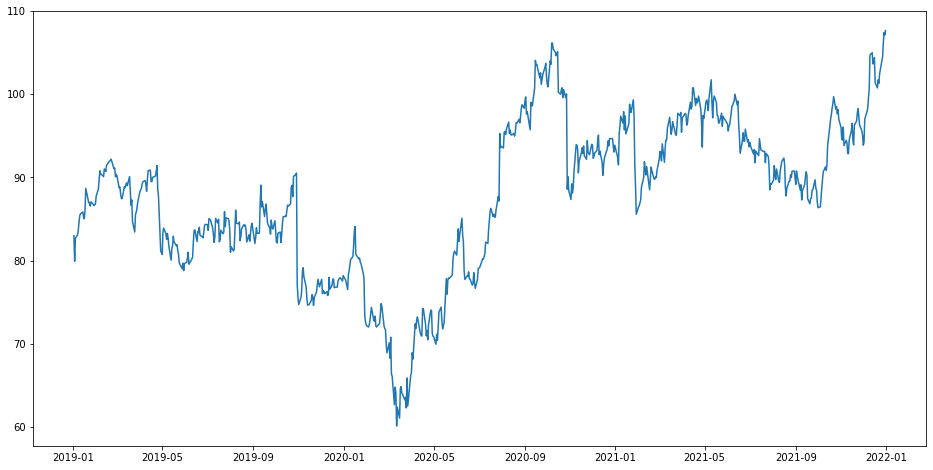

In [4]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df_ch_robinson['Close'], label='Close Price History')

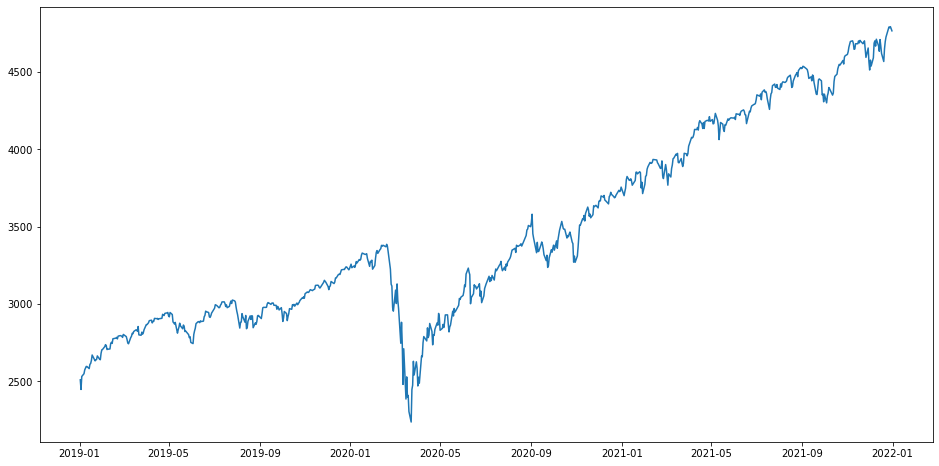

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df_sp['Close'], label='Close Price History')

Looking at the Distribution of the Dataset

<AxesSubplot:ylabel='Density'>

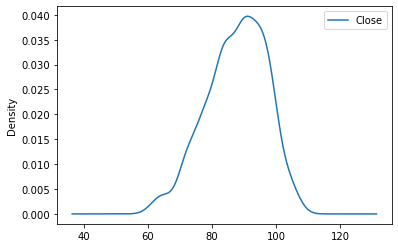

In [8]:
df_ch_robinson_close = df_ch_robinson[['Close']]
df_ch_robinson_close.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

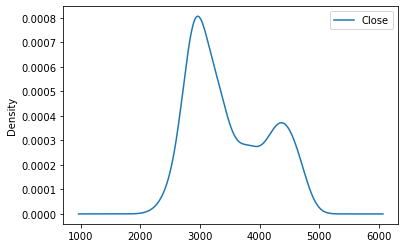

In [9]:
df_sp_close = df_sp[['Close']]
df_sp_close.plot(kind='kde')

Splitting Data into Train and Test DataSet into 80% Training Data and 20% Testing Data

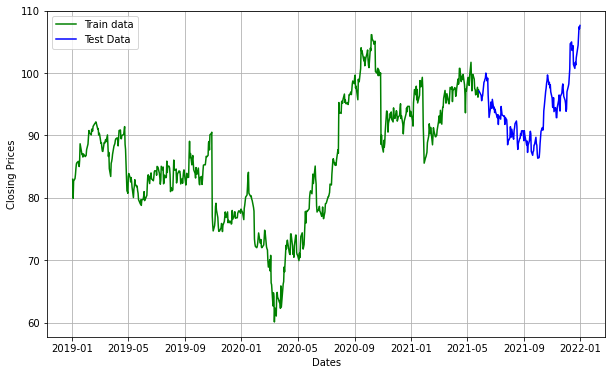

In [21]:
ch_train_data= df_ch_robinson_close.iloc[:int(df_ch_robinson_close.shape[0]*0.8)]
ch_test_data = df_ch_robinson_close.iloc[int(df_ch_robinson_close.shape[0]*0.80):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ch_train_data, 'Green', label='Train data')
plt.plot(ch_test_data, 'blue',  label='Test Data')
plt.legend()

This Machine Learning Model will run a linear regression, ARIMA model, and a Facebook Prophet model
- limitations of these models will be they do not take into account current world situations (like COVID impacts on economy)

Linear Regression Model

In [22]:
df_linear_ch = pd.merge(df_ch_robinson_close, df_sp_close, on='Date')
df_linear_ch = df_linear_ch.rename(columns={'Close_x': 'CH Robinson Close', 'Close_y':'S&P Close'})

In [23]:
# for linear regression model we need an x_train value, and a y_train value
X_train, X_test, y_train, y_test = train_test_split(df_linear_ch[['CH Robinson Close']], df_linear_ch[['S&P Close']], test_size=.2)

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = linear_regression_model.predict(X_test)

In [25]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [26]:
print('Mean Absolute Error:', mae)
print('Coefficient of Determination:', r2)
print('Mean Squared Error:', mse)

Mean Absolute Error: 376.93178565941383
Coefficient of Determination: 0.4335583134308033
Mean Squared Error: 222976.1401345517


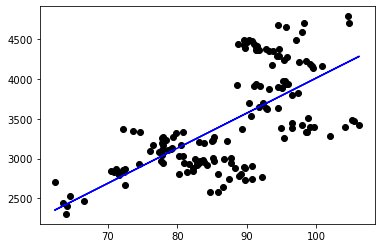

In [27]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue')
plt.show()

Arima Model

In [28]:
# ARIMA Model
arima_model = pm.auto_arima(ch_train_data, d=1, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=6, max_order=None , trace=True)

arima_model.fit(ch_train_data)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2258.717, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2257.605, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2256.379, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2256.646, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2255.744, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2256.185, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.713 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [29]:
arima_y_pred = ch_test_data.copy()

# Forecasting the Data
prediction_arima = arima_model.predict(len(ch_test_data))
arima_y_pred["ARIMA Model Prediction"]=prediction_arima

In [31]:
r2_arima = r2_score(arima_y_pred["Close"], arima_y_pred["ARIMA Model Prediction"])
mae_arima = mean_absolute_error(arima_y_pred["Close"], arima_y_pred["ARIMA Model Prediction"])
mse_arima = mean_squared_error(arima_y_pred['Close'], arima_y_pred["ARIMA Model Prediction"])

print('Mean Absolute Error for ARIMA Model:', mae_arima)
print('Coefficient of Determination for ARIMA Model:', r2_arima)
print('Mean Squared Error for ARIMA Model:', mse_arima)

Mean Absolute Error for ARIMA Model: 4.8533534501728255
Coefficient of Determination for ARIMA Model: -0.4274620977309538
Mean Squared Error for ARIMA Model: 32.884968081720885


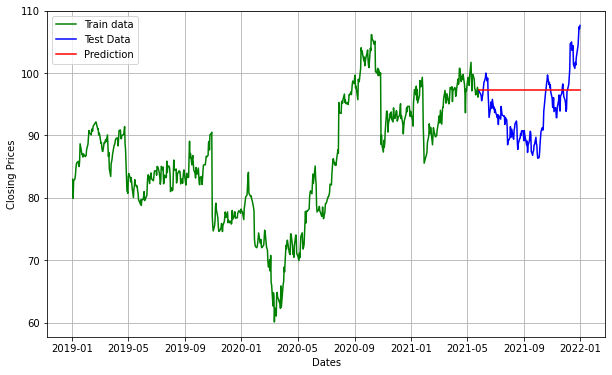

In [33]:
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ch_train_data, 'Green', label='Train data')
plt.plot(ch_test_data, 'blue',  label='Test Data')
plt.plot(arima_y_pred["ARIMA Model Prediction"], 'Red', label='Prediction')
plt.legend()


Facebook Prophet Model with Plot of Actual vs Predictions

In [34]:
# Facebook Prophet Model
prophet_data = df_ch_robinson_close.copy()
prophet_data = prophet_data.reset_index()

#preparing data
prophet_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
prophet_train = prophet_data[:int(prophet_data.shape[0]*0.80)]
prophet_test = prophet_data[int(prophet_data.shape[0]*0.80):]

#fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

#predictions
close_prices = prophet_model.make_future_dataframe(periods=len(prophet_test))
forecast = prophet_model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.45169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1795.98    0.00572709       110.403           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       1803.76   9.91292e-05       109.275   3.727e-07       0.001      233  LS failed, Hessian reset 
     199       1808.84    0.00516651       359.941           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1824.05     0.0141938       473.006           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1828.44    0.00519461       156.565      0.8141      0.8141      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       1828.84    0.00013085    

In [35]:
forecast = forecast.set_index('ds')
forecast = forecast.rename(columns={'yhat':'Prediction'})

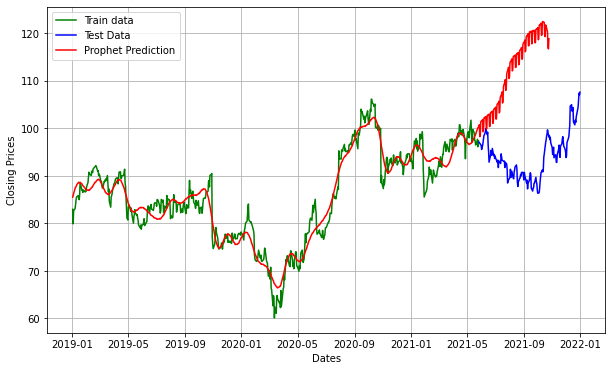

In [36]:
# Facebook Prophet Models
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ch_train_data, 'Green', label='Train data')
plt.plot(ch_test_data, 'blue',  label='Test Data')
plt.plot(forecast['Prediction'], 'Red', label='Prophet Prediction')
plt.legend()


#Will need to update model so it predicts full test data


In [177]:
# Get Statistics for Prophet Predictions